# Projecte GDSA:

Aquesta Notebook preten mostrar totes les parts del codi del projecte del grup Terrassa's Buildings, per a fer-lo tenim en compte la funció get_params.py on creem els directoris i inicialitzem els parametres necessàris per algunes funcions amb l'objectiu de simplificar el programa i que podeu trobar al nostre repositori del github.

L'esquema del projecte és el següent:
    - Creació de la base de dades
    - Obtenció de les característiques de les imatges d'entrenament i validació
    - Creació d'un ranking de semblança per a cada imatge de validació
    - Evaluació del ranking amb les imatges de validació conegudes

## Creació de la base de dades:

Amb aquesta funció generem un fitxer txt que conté tots els IDs de les imatges de la base de dades.

In [1]:
import os
from get_params import get_params

def build_database(params):

    # List images
    image_names = os.listdir(os.path.join(params['root'],params['database'],params['split'],'images'))

    # File to be saved
    outfile = open(os.path.join(params['root'],params['root_save'],params['image_lists'],params['split'] + '.txt'),'w')

    # Save image list to disk
    for file in image_names:
        outfile.write(file +'\n')

    outfile.close()


if __name__=="__main__":

    params = get_params()

    # Build image list for validation set
    build_database(params)

    # Switch to training set
    params['split'] = 'train'

    # Build image list for training set
    build_database(params)

## Obtenció de característiques:

Amb aquesta funció extreiem els descriptors locals de cada imatge amb local_features() utilitzant el descriptor ORB i normalitzem per obtenir rangs entre 0 i 1. Amb la matriu de descriptors generem un codebook, és a dir, realitzem un entrenament per a que trobi els centroids i amb get_assignments() assignem per a cada descriptor el seu centroid més pròxim. Generem un BOW per a cada imatge i guardarem tots els resultats a un diccionari el qual escriurem en un fitxer per a poder utilitzar els resultats en les següents funcions.

In [2]:
# -*- coding: cp1252 -*-
from get_params import get_params
import sys
#from rootsift import RootSIFT
import os, time
import numpy as np
import pickle
import cv2
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfTransformer
import warnings
warnings.filterwarnings("ignore")


def get_features(params,pca=None,scaler=None):

    # Read image names
    with open(os.path.join(params['root'],params['root_save'],params['image_lists'],params['split'] + '.txt'),'r') as f:
        image_list = f.readlines()

    # Initialize keypoint detector and feature extractor
    #detector, extractor = init_detect_extract(params)

    # Initialize feature dictionary
    features = {}

    # Get trained codebook
    km = pickle.load(open(os.path.join(params['root'],params['root_save'],
                                     params['codebooks_dir'],'codebook_'
                                     + str(params['descriptor_size']) + "_"
                                     + params['descriptor_type']
                                     + "_" + params['keypoint_type'] + '.cb'),'rb'))

    for image_name in image_list:
        image_name=image_name.replace('\n','')
        # Read image
        im = cv2.imread(os.path.join(params['root'],params['database'],params['split'],'images',image_name))

        # Resize image
        im = resize_image(params,im)

        # Extract local features
        feats = image_local_features(im)

        if feats is not None:

            if params['normalize_feats']:
                feats = normalize(feats)

            # If we scaled training features
            if scaler is not None:
                scaler.transform(feats)

            # Whiten if needed
            if pca is not None:

                pca.transform(feats)

            # Compute assignemnts
            assignments = get_assignments(km,feats)

            # Generate bow vector
            feats = bow(assignments,km)
        else:
            # Empty features
            feats = np.zeros(params['descriptor_size'])

        # Add entry to dictionary
        features[image_name] = feats


    # Save dictionary to disk with unique name
    save_file = os.path.join(params['root'],params['root_save'],params['feats_dir'],
                             params['split'] + "_" + str(params['descriptor_size']) + "_"
                             + params['descriptor_type'] + "_" + params['keypoint_type'] + '.p')

    pickle.dump(features,open(save_file,'wb'))


def resize_image(params,im):

    # Get image dimensions
    height, width = im.shape[:2]

    # If the image width is smaller than the proposed small dimension, keep the original size !
    resize_dim = min(params['max_size'],width)

    # We don't want to lose aspect ratio:
    dim = (resize_dim, height * resize_dim/width)

    # Resize and return new image
    return cv2.resize(im,dim)



def image_local_features(image):
    #llegim la imatge:
    #img = cv2.imread(image)
    #Cambiem la mida de la imatge:
    if not image is None:

        #linea que soluciona un bug de opencv a python3
        #cv2.ocl.setUseOpenCL(False)

        # Creem l'objecte ORB que tindrà 200k keypoints. (Perametre que podem modificar per no saturar el programa)
        orb = cv2.ORB(200000)

        # Detectem els keypoints:
        kp = orb.detect(image,None)

        # Calculem els descriptors amb els keypoints trobats.
        kp, des = orb.compute(image, kp)

        # la sortida de la funció serà els descriptors
        return des

def stack_features(params):

    '''
    Get local features for all training images together
    '''

    # Init detector and extractor
    #detector, extractor = init_detect_extract(params)

    # Read image names
    with open(os.path.join(params['root'],params['root_save'],params['image_lists'],params['split'] + '.txt'),'r') as f:
        image_list = f.readlines()

    X = []
    for image_name in image_list:
        image_name=image_name.replace('\n','') #Afegim el replace per ignorar el caràcter /n

        # Read image
        im = cv2.imread(os.path.join(params['root'],params['database'],params['split'],'images',image_name))

        # Resize image
        im = resize_image(params,im)

        #feats = image_local_features(im,detector,extractor)
        feats=image_local_features(im)
        # Stack all local descriptors together

        if feats is not None:
            if len(X) == 0:

                X = feats
            else:
                X = np.vstack((X,feats))

    if params['normalize_feats']:
        X = normalize(X)

    if params['whiten']:

        pca = PCA(whiten=True)
        pca.fit_transform(X)

    else:
        pca = None

    # Scale data to 0 mean and unit variance
    if params['scale']:

        scaler = StandardScaler()

        scaler.fit_transform(X)
    else:
        scaler = None

    return X, pca, scaler

def train_codebook(params,X):

    # Init kmeans instance
    km = MiniBatchKMeans(params['descriptor_size'])

    # Training the model with our descriptors
    km.fit(X)

    # Save to disk
    pickle.dump(km,open(os.path.join(params['root'],params['root_save'],
                                     params['codebooks_dir'],'codebook_'
                                     + str(params['descriptor_size']) + "_"
                                     + params['descriptor_type']
                                     + "_" + params['keypoint_type'] + '.cb'),'wb'))

    return km

def get_assignments(km,descriptors):

    assignments = km.predict(descriptors)

    return assignments


def bow(assignments,km):

    # Initialize empty descriptor of the same length as the number of clusters
    descriptor = np.zeros(np.shape(km.cluster_centers_)[0])

    # Build vector of repetitions
    for a in assignments:

        descriptor[a] += 1

    # L2 normalize
    descriptor = normalize(descriptor)

    return descriptor



if __name__ == "__main__":

    params = get_params()

    # Change to training set
    params['split'] = 'train'

    print "Stacking features together..."
    # Save features for training set
    t = time.time()
    X, pca, scaler = stack_features(params)
    print "Done. Time elapsed:", time.time() - t
    print "Number of training features", np.shape(X)

    print "Training codebook..."
    t = time.time()
    train_codebook(params,X)
    print "Done. Time elapsed:", time.time() - t

    print "Storing bow features for train set..."
    t = time.time()
    get_features(params, pca,scaler)
    print "Done. Time elapsed:", time.time() - t

    params['split'] = 'val'

    print "Storing bow features for validation set..."
    t = time.time()
    get_features(params)
    print "Done. Time elapsed:", time.time() - t


Stacking features together...
Done. Time elapsed: 44.1014909744
Number of training features (1073104, 32)
Training codebook...
Done. Time elapsed: 224.018777847
Storing bow features for train set...
Done. Time elapsed: 101.189646006
Storing bow features for validation set...
Done. Time elapsed: 40.944229126


## Creació del ranking:

Amb aquesta funció importem el resultat anterior i l'utilitzem per comparar per a cada imatge de validació quines són les imatges d'entrenament que més s'assemblen, és a dir quines són les imatges d'entrenament amb un BoW més semblant. La funció crearà un fitxer per a cada imatge de validació que contindrà una llista amb els IDs de les imatges d'entrenament ordenada de més a menys semblança (de menys a més distancia).

In [3]:
import os
import pickle
import numpy as np
from get_params import get_params
from sklearn.metrics.pairwise import pairwise_distances

def rank(params):

    # Load train and validation feature dictionaries
    val_features = pickle.load(open(os.path.join(params['root'],params['root_save'],params['feats_dir'],
                             params['split'] + "_" + str(params['descriptor_size']) + "_"
                             + params['descriptor_type'] + "_" + params['keypoint_type'] + '.p'),'rb'))

    train_features = pickle.load(open(os.path.join(params['root'],params['root_save'],params['feats_dir'],
                             'train' + "_" + str(params['descriptor_size']) + "_"
                             + params['descriptor_type'] + "_" + params['keypoint_type'] + '.p'),'rb'))


    # For each image id in the validation set
    for val_id in val_features.keys():

        # Get its feature
        bow_feats = val_features[val_id]

        # The ranking is composed with the ids of all training images
        ranking = train_features.keys()

        X = np.array(train_features.values())

        # The .squeeze() method reduces the dimensions of an array to the minimum. E.g. if we have a numpy array of shape (400,1,100) it will transform it to (400,100)
        distances = pairwise_distances(bow_feats,X.squeeze())


        # Sort the ranking according to the distances. We convert 'ranking' to numpy.array to sort it, and then back to list (although we could leave it as numpy array).
        ranking = list(np.array(ranking)[np.argsort(distances.squeeze())])

        # Save to text file
        outfile = open(os.path.join(params['root'],params['root_save'],params['rankings_dir'],params['descriptor_type'],params['split'],val_id.split('.')[0] + '.txt'),'w')

        for item in ranking:

            outfile.write(item.split('.')[0] + '\n')

        outfile.close()

if __name__ == "__main__":

    params = get_params()
    rank(params)


## Evaluació del Ranking

Utilitzant el fitxer d'anotacions que conté les etiquetes per a cada imatge podem calular el percentatge d'accerts que hem tingut al calcular el ranking. Mostrarem una imatge de validació d'exemple amb els resultats obtinguts on podrem veure en verd les imatges d'entrenament que s'han predit correctament i en vermell les que no. L'script donarà com a resultat l'accuracy, és a dir el percentatge d'acerts que hem tingut per a cada etiqueta i la mitjana de tots ells. 

ajuntament
450
Displaying...


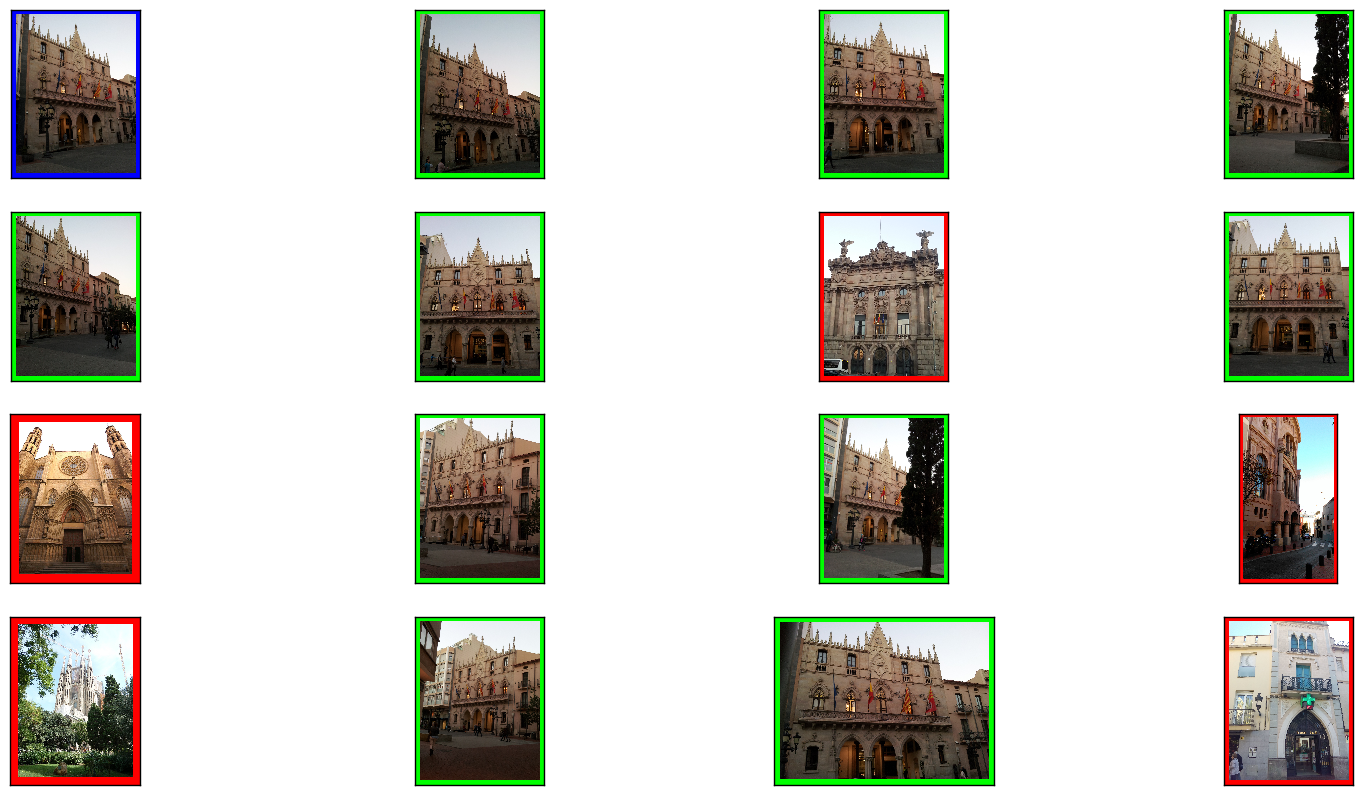

Accuracy:
Mean: 0.124031198012
mercat_independencia: 0.143214245263
societat_general: 0.148260154605
farmacia_albinyana: 0.10516961399
ajuntament: 0.328572303191
mnactec: 0.0700127620378
escola_enginyeria: 0.146032058084
masia_freixa: 0.098545244055
castell_cartoixa: 0.122804285056
dona_treballadora: 0.113879015503
catedral: 0.0681311197188
teatre_principal: 0.0908849499532
estacio_nord: 0.0528686246826


In [8]:
import os, sys
import pandas as pd
import numpy as np
from get_params import get_params
import matplotlib.pyplot as plt
import cv2

def display(params,query_id,ranking,relnotrel):

    ''' Display the first elements of the ranking '''


    # Read query image
    query_im =  cv2.imread(os.path.join(params['root'],params['database'],params['split'], 'images',query_id.split('.')[0] + '.jpg'))

    # Handling the duality in file terminations. I know it's not pretty, but it works...
    if query_im is None:
        query_im =  cv2.imread(os.path.join(params['root'],params['database'],params['split'], 'images',query_id.split('.')[0] + '.JPG'))

    # Blue contour for the query

    query_im = cv2.cvtColor(query_im,cv2.COLOR_BGR2RGB)
    query_im = cv2.copyMakeBorder(query_im,100,100,100,100,cv2.BORDER_CONSTANT,value=[0,0,255])
    # Init figure
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(4, 4, 1)

    # Display
    ax.imshow(query_im)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)


    # We will show the first 15 elements of the ranking
    for i in range(15):

        # Read image

        im =  cv2.imread(os.path.join(params['root'],params['database'],'train','images',ranking[0].tolist()[i] + '.jpg'))

        # Handling the duality in file terminations. I know it's not pretty, but it works...
        if im is None:

            im =  cv2.imread(os.path.join(params['root'],params['database'],'train', 'images',ranking[0].tolist()[i] + '.JPG'))

        # Switch to RGB to display with matplotlib
        im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)

        # Paint the boundaries with the ground truth

        # If it was correctly selected
        if relnotrel[i] == 1:
            # Put green contour
            im = cv2.copyMakeBorder(im,100,100,100,100,cv2.BORDER_CONSTANT,value= [0,255,0])

        # If it was not
        else:
            # Put red contour
            im = cv2.copyMakeBorder(im,100,100,100,100,cv2.BORDER_CONSTANT,value= [255,0,0])

        # Show in figure
        ax = fig.add_subplot(4, 4, i+2)
        ax.imshow(im)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

    print "Displaying..."
    plt.show()

def read_annotation(params):

    # Get true annotations
    annotation_val = pd.read_csv(os.path.join(params['root'],params['database'],params['split'],'annotation.txt'), sep='\t', header = 0)
    annotation_train = pd.read_csv(os.path.join(params['root'],params['database'],'train','annotation.txt'), sep='\t', header = 0)

    return annotation_val,annotation_train

def get_hitandmiss(ranking,query_class,annotation_train):

    # Initialize hit/miss list
    relnotrel = []

    # For each image id in the ranking...
    for i in ranking[0].tolist():

        # Get its class from the training annotations
        i_class = list(annotation_train.loc[annotation_train['ImageID'] == i]['ClassID'])[0]

        # And if it matches the query class...
        if query_class == i_class:

            # Then it means it's correct
            relnotrel.append(1)
        else:

            # If it doesn't, then we failed :(
            relnotrel.append(0)

    return relnotrel

def AveragePrecision(relist):
    '''Takes a hit & miss list with ones and zeros and computes its average precision'''

    # Initialize the accumulated sum of precisions
    accu = 0

    # Initialize the number of correct instances found so far
    numRel = 0

    # For all elements in the hit & miss list
    for k in range(len(relist)):

        # If the value is 1
        if relist[k] == 1:

            # We add 1 to the number of correct instances
            numRel = numRel + 1

            # We calculate the precision at k (+1 because we start at 0) and we accumulate it
            accu += float( numRel )/ float(k+1)

    # When we finish, we divide by the total number of relevant instances, which is the sum of ones in the list
    return (accu/np.sum(relist))

def load_ranking(params,query_id, annotation_val):

    ''' Loads and  returns the ranking from the txt. Returns the true class of the query image as well.'''

    # Get the true class of the validation image for which we will evaluate the ranking
    query_class = list(annotation_val.loc[annotation_val['ImageID'] == query_id.split('.')[0]]['ClassID'])[0]

    # Open its ranking file
    ranking = pd.read_csv(os.path.join(params['root'],params['root_save'],params['rankings_dir'],params['descriptor_type'],params['split'],query_id.split('.')[0] + '.txt'),header= None)

    return query_class, ranking

#ha sortit del kaggle script
def save_ranking_file(file_to_save,image_id,ranking):

    '''
    :param file_to_save: name of the file to be saved
    :param image_id: name of the query image
    :param ranking: ranking for the image image_id
    :return: the updated state of the file to be saved
    '''

    # Write query name
    file_to_save.write(image_id.split('.')[0] + ',')

    # Convert elements to string and ranking to list
    ranking = np.array(ranking).astype('str').tolist()

    # Write space separated ranking
    for item in ranking:
        file_to_save.write(item[0] + " ")

    file_to_save.write('\n')

    return file_to_save

def eval_rankings(params):

    ap_list = []

    # Prepare to save kaggle friendly file with all rankings
    if params['save_for_kaggle']:

        file_to_save = open(os.path.join(params['root'],params['root_save'],params['kaggle_dir'],params['descriptor_type'] + '_' + params['split'] + '_ranking.csv'),'w')

        # Write first line with header
        file_to_save.write("Query,RetrievedDocuments\n")

    # Create a dictionary to store the accumulated AP for each class
    dict_ = {key: 0 for key in params['possible_labels']}

    # Get true annotations
    annotation_val, annotation_train = read_annotation(params)

    '''
    # Used once to save ranking annotations for kaggle competition.
    gt_file_to_save = open(os.path.join(params['root'],params['root_save'],params['kaggle_dir'],params['split'] + '_rankingannotation.csv'),'w')
    kaggle_scripts.convert_ranking_annotation(annotation_val,annotation_train,gt_file_to_save)
    '''

    # For all generated rankings
    for val_id in os.listdir(os.path.join(params['root'],params['root_save'],params['rankings_dir'],params['descriptor_type'],params['split'])):

        query_class, ranking = load_ranking(params,val_id,annotation_val)

        # We do not evaluate the queries in the unknown class !
        if not query_class == "desconegut":
            #single_eval(params,val_id)  # activant aquesta linea fem un display per veure quines de les 10 primeres imatges s'han predit correctament i quines no
            if params['save_for_kaggle']:

                file_to_save = save_ranking_file(file_to_save,val_id,ranking)

            # Get the hit & miss list
            relnotrel = get_hitandmiss(ranking,query_class,annotation_train)

            # Calculate average precision of the list
            ap = AveragePrecision(relnotrel)


            # OPTIONAL: Add the AP to the according dictionary entry
            dict_[query_class] += ap

            # Store it
            ap_list.append(ap)

    single_eval(params,'168-2743-15592.txt')  # activant aquesta linea fem un display per veure quines de les 10 primeres imatges s'han predit correctament i quines no
    if params['save_for_kaggle']:

        file_to_save.close()

    return ap_list, dict_

def single_eval(params,query_id):

    # We get the true annotations of both sets. We do this in order to display this information as well.
    annotation_val, annotation_train = read_annotation(params)

    # We get the ranking and the true class of the query
    query_class, ranking = load_ranking(params,query_id,annotation_val)

    # I made sure I was not picking an image from the "desconegut" class ...
    print query_class

    # The ranking is composed of the training images. It should be of size 450.
    print len(ranking)

    # We get the hit/miss list for the ranking
    relnotrel = get_hitandmiss(ranking,query_class,annotation_train)

    display(params,query_id,ranking,relnotrel)

if __name__ == "__main__":

    params = get_params()

    ap_list, dict_ = eval_rankings(params)
    print 'Accuracy:'
    print 'Mean:',np.mean(ap_list)

    for id in dict_.keys():
        if not id == 'desconegut':
            # We divide by 10 because it's the number of images per class in the validation set.
            print id+':', dict_[id]/10


Com veiem hem obtingut una mitjana d'acerts del 12'4% i aquest és el percentatge del que partim per a millorar el programa. Degut a aquest resultat podem intuir que la imatge que s'ha mostrat on hi han 10 matchings correctes de 15 ha sigut una excepció dins el set d'imatges.